# Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

Попробуем выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.


In [ ]:
import os
import tqdm
import numpy
import torch
import torch.nn as nn
import pandas
import numpy as np
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2
from torch.utils.data import DataLoader
from PIL import Image


In [ ]:
def set_random_seed(seed: int = 42):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Подготовка данных

In [ ]:
%%bash
wget -O data.zip "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fNzKjmboX29MRg"
unzip -q data.zip
rm data.zip
du -sh .

73M	.


--2025-11-02 20:55:08--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fNzKjmboX29MRg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 138.199.175.196
Connecting to getfile.dokpub.com (getfile.dokpub.com)|138.199.175.196|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/e09fc991ff7a2a2b70dba4079ed7b028ffc7c147f363e1882e99648daeba901b/6907fd6d/fKqInKw3d7bLFOeFnMGnhMU-Am0OwZYgkShFVCMHfRuRjN7sWOEDg7cNxYR_ZynzNkQak_EceScU48YO2gia0B0aqzJ1x841oKKLZxSfT0-r8npumZHI4midPdWhecNq?uid=0&filename=data.zip&disposition=attachment&hash=NgHo1sc6TgTnFTPH7Btu2ing4VKWUl%2B25yhd2kl8V8PqSbLi/rurAuUlWumsmYg9q/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=1510941353&fsize=15771850&hid=b448493f9a294048b39b18b1dba9c2b3&media_type=compressed&tknv=v3 [following]
--2025-11-02 20:55:09--  https://downloader.disk.yandex.ru/disk/e09fc991ff7a2a2b70dba4079ed7b028ffc7c147f363e1882e99648daeba901b/6907

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(400),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()])

train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform)

Давайте посмотрим на примеры фотографий

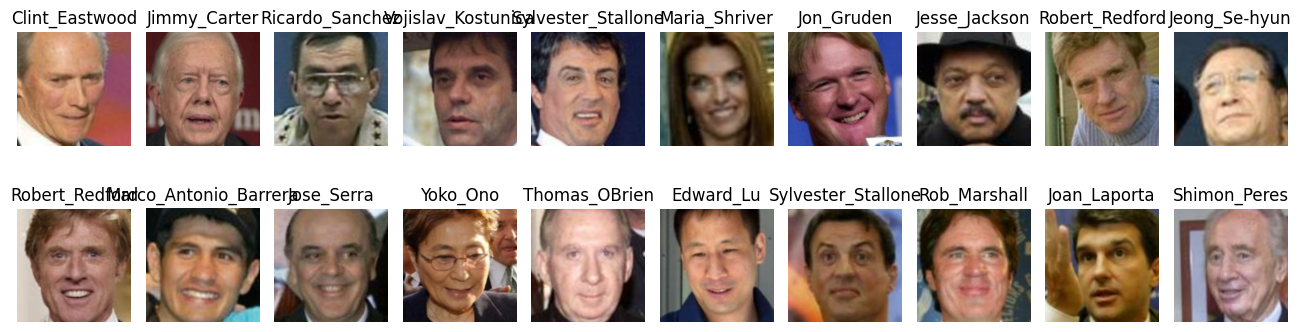

In [ ]:
def images(data):
            fig, axes = plt.subplots(2, 10, figsize=(13, 4))
            axes = axes.ravel()
            ind = np.random.choice(len(data), 20, replace=False)

            for i in range(len(ind)):
                image, label = data[ind[i]]

                axes[i].imshow(np.transpose(image, (1, 2, 0)));
                axes[i].set_title(f'{data.classes[label]}')
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

images(train_ds)

In [ ]:
train_ds = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False)

def mean_std(loader):
  mean_sp, std_sp = [], []
  count = 0

  for images, _ in loader:
      batch = images.size(0)
      images = images.view(batch, images.size(1), -1)
      mean_sp.append(images.mean(2))
      std_sp.append(images.std(2))
  mean = torch.cat(mean_sp).mean(0)
  std = torch.cat(std_sp).mean(0)
  return mean, std

mean, std = mean_std(train_ds)
print(mean, std)

tensor([0.5323, 0.4219, 0.3484]) tensor([0.2390, 0.2044, 0.1925])


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(400),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean.tolist(), std.tolist())
])
train_ds = torchvision.datasets.ImageFolder("data/training", transform=transform)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform=transform)

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

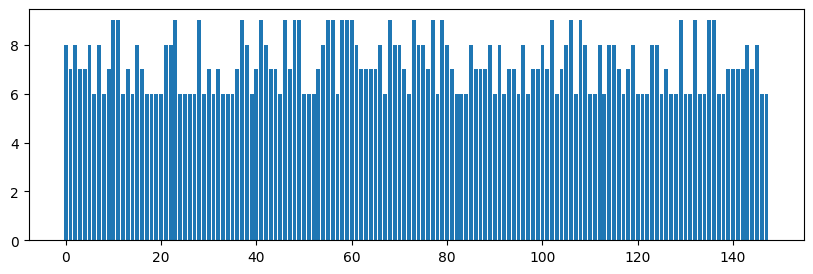

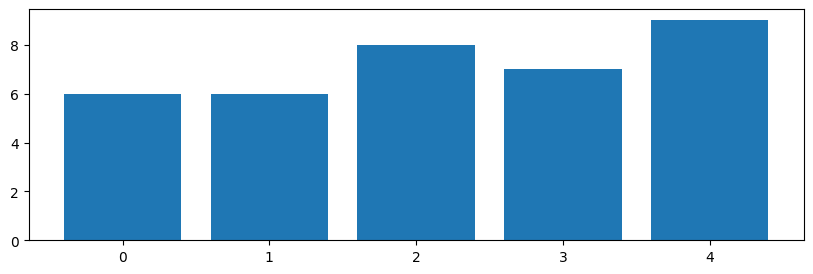

In [ ]:
def show_class_distribtion(targets):
    unique, counts = np.unique(np.array(targets), return_counts=True)
    plt.figure(figsize=(10, 3))
    plt.bar(unique, counts)
    plt.show()

show_class_distribtion(train_ds.targets)
show_class_distribtion(test_ds.targets)

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \


In [ ]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<00:00, 710564.44it/s]


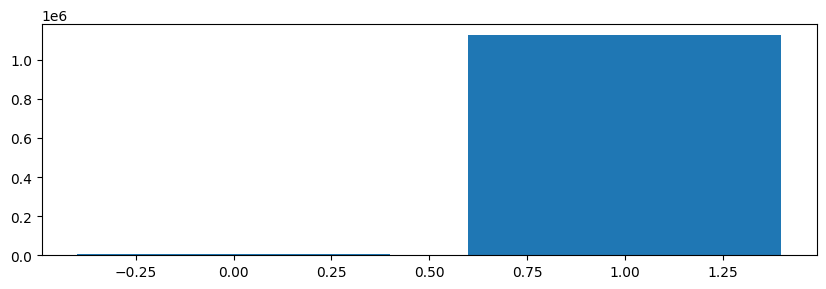

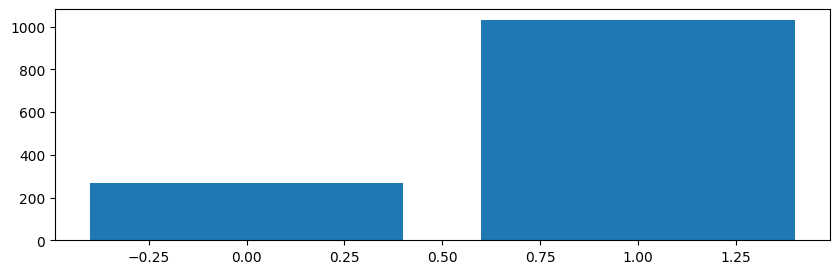

In [ ]:
show_class_distribtion(train_pairs.targets)
show_class_distribtion(test_pairs.targets)

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

#####  Стратифицированный даталоадер

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".



In [ ]:
class Sampler(torch.utils.data.Sampler):
  def __init__(self, data, batch_size=32, pairs=50000):
    self.data = data
    self.batch_size = batch_size
    self.pairs = pairs
    self.ind_zeros = [i for i in range(len(self.data.targets)) if self.data.targets[i] == 0]
    self.ind_ones = [i for i in range(len(self.data.targets)) if self.data.targets[i] == 1]

  def __iter__(self):
    batches = self.pairs // self.batch_size
    for i in range(batches):
        ind_zeros = np.random.choice(self.ind_zeros, size=self.batch_size // 2, replace=True)
        ind_ones = np.random.choice(self.ind_ones, size=self.batch_size // 2, replace=True)

        ind = np.concatenate([ind_zeros, ind_ones])
        np.random.shuffle(ind)
        yield from iter(ind)

  def __len__(self):
    return self.pairs

In [ ]:
set_random_seed()
train_pairs_sampler = Sampler(train_pairs, batch_size=32)

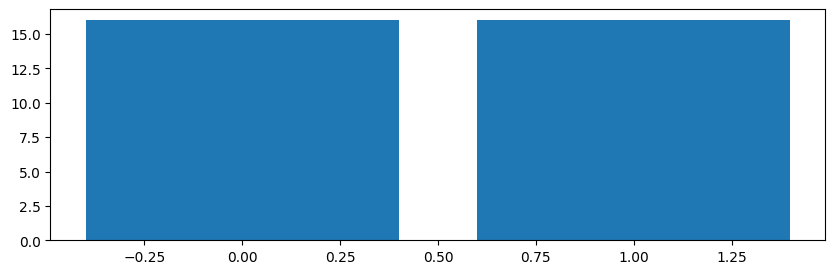

In [ ]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler, pin_memory=True,
    num_workers=2)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.
show_class_distribtion(next(iter(train_pairs_loader))[2])

### Классификация

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуем и обучим обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### Модель классификации

In [ ]:
class ClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, image1, image2):
        emb1 = self.encoder(image1)
        emb2 = self.encoder(image2)

        out = self.classifier(torch.abs(nn.Flatten()(emb1) - nn.Flatten()(emb2))).squeeze(1)
        return out


assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)


##### Обучение

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader):

    model.train()
    train_loss = 0.0

    for image1, image2, labels in train_loader:
        image1, image2, labels = image1.to(device), image2.to(device), labels.float().to(device)

        optimizer.zero_grad()
        out = model(image1, image2)

        loss = criterion(out, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)

    return train_loss / len(train_loader.dataset)

@torch.no_grad()
def predict(model, loader):
    model.eval()
    outs = []

    for image1, image2, _ in loader:
        image1, image2 = image1.to(device), image2.to(device)
        pred = model(image1, image2)
        outs.append(pred.cpu())

    return torch.cat(outs, dim=0)


def train(model, optimizer, criterion, train_loader, epochs):
    losses = []

    for i in range(epochs):
        loss = training_epoch(model, optimizer, criterion, train_loader)
        losses.append(loss)

    return losses

In [ ]:
set_random_seed()
model = ClassificationNet().to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses = train(model, optimizer, criterion, train_pairs_loader, epochs=5)
train_losses

[0.028340433838742202,
 0.027020377707519746,
 0.02529903614249601,
 0.024092982104105817,
 0.0229943388057918]

In [ ]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

auc = get_auc_roc(model)

print(get_score(auc), auc)

100%|██████████| 21/21 [00:12<00:00,  1.74it/s]

2.5 0.8666618001313964


##### Анализ и отчет

Сначала пробовала взять столько пар в эпоху, сколько есть пар нулевого класса * 2(около 14к), но этого оказалось недостаточно для обучения нейронки, поэтому решила просто брать рандомные индексы, сначала проверила колличество пар равно 30к, но этого также не хватила, в итоге остановилась на 50к пар.

Также эксперементировала с количеством слоев и эпох, сначала взяла побольше, но оказалось, что 3 слоев и 5 эпох вполне достаточно.

Результат нетакой плохой, его можно было улучшить, если увеличить количество эпох, но решать задачу через классификацию правда не лучшая идея, тк:

1. Огромное количество пар изза того, что датасет большой, невозможно создать все пары и обучаться на них, поэтому пришлось ограничить колличество пар в эпоху. Но это все равно занимает больше часа обучения!

2. Модель учится только предсказывать вероятность пары, но не учится строить общее представление о лице каждого человека. Если мы захотим использовать модель для задач поиска или верификации лиц, такой подход бесполезен, тк надо заново ее обучать.

3. Нельзя использовать новые изображения без дообучения, поэтому если появилось желание добавить нового человека, нужно формировать новые пары и дообучать модель еще час или более.

### Распознавание лиц

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### Триплетная функция потерь

Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$



In [ ]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=0.25):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        batch_size = embeddings.size(0)
        loss = 0.0
        n_triplets = 0

        dist = torch.cdist(embeddings, embeddings, p=2)

        for a in range(batch_size):
            for p in range(batch_size):
                if a != p:
                  if labels[a] == labels[p]:
                    for n in range(batch_size):
                        if labels[a] != labels[n]:
                            dist_ap = dist[a, p]
                            dist_an = dist[a, n]
                            triplet_loss = torch.max(dist_ap - dist_an + self.margin, torch.tensor(0.0, device=device))
                            if triplet_loss > 0:
                              loss += triplet_loss
                              n_triplets += 1
        if n_triplets == 0:
            return torch.tensor(0.0, device=device)
        return loss / n_triplets


In [ ]:
criterion = TripletLoss(margin=0.15)

##### Обучение

In [ ]:
def training_epoch(model, optimizer, criterion, train_loader):

    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()

      emb = model(images)

      loss = criterion(emb, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * len(labels)

    return train_loss / len(train_loader.dataset)


@torch.no_grad()
def predict(model, loader):
    model.eval()
    embeddings = []

    for images, _ in loader:
        images = images.to(device)
        emb = model(images)
        embeddings.append(emb.cpu())

    return torch.cat(embeddings, dim=0)


def train(model, optimizer, criterion, train_loader, epochs):
    losses = []

    for i in range(epochs):
        loss = training_epoch(model, optimizer, criterion, train_loader)
        losses.append(loss)

    return losses

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_size=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))
        self.classifier = nn.Linear(512, embedding_size)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.Flatten()(x)
        x = self.classifier(x)
        return x

In [ ]:
set_random_seed()
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 64, pin_memory=True, num_workers=4)
model = EmbeddingNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = train(model, optimizer, criterion, train_loader, epochs=20)
train_losses

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[0.6821604263334767,
 0.30914286631093896,
 0.24750206245223122,
 0.22322293959313155,
 0.22109681359479125,
 0.2026778710140309,
 0.21988944197204752,
 0.21408583970976547,
 0.19849269646154324,
 0.18260553828987158,
 0.19682160098228096,
 0.18255521881748255,
 0.18401744676307893,
 0.18447353519464324,
 0.18951065184924523,
 0.19682552596213113,
 0.18148354595535798,
 0.1729013879604183,
 0.1790204307632827,
 0.17209737907413025]

In [ ]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))

            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

auc = get_auc_roc(model)

print(get_score(auc), auc)

100%|██████████| 21/21 [00:12<00:00,  1.70it/s]

2.484560916855245 0.9242280458427623


Результат намного лучше!!!

Ради интереса загрузила свою фотографию, чтобы определить на кого из известных людей, по мнению модели, я больше всего похожа.

In [ ]:
%%bash
wget -O photo.jpg "https://drive.google.com/uc?id=119dAJ0ORLrZXZkhLxuML9pYvy7K895Cy"

--2025-11-01 15:19:21--  https://drive.google.com/uc?id=119dAJ0ORLrZXZkhLxuML9pYvy7K895Cy
Resolving drive.google.com (drive.google.com)... 142.250.4.100, 142.250.4.102, 142.250.4.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=119dAJ0ORLrZXZkhLxuML9pYvy7K895Cy [following]
--2025-11-01 15:19:21--  https://drive.usercontent.google.com/download?id=119dAJ0ORLrZXZkhLxuML9pYvy7K895Cy
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157125 (153K) [image/jpeg]
Saving to: ‘photo.jpg’

     0K .......... .......... .......... .......... .......... 32% 14.5M 0s
    50K .......... .......... .......... .......... ........

In [ ]:
img = Image.open("photo.jpg")
img = transform(img).unsqueeze(0)

embs, labels = [], []

model.eval()
with torch.no_grad():
    embs, labels = zip(*[(model(img), labels) for img, label in train_loader])

embs = torch.cat(embs, dim=0)
label = torch.cat(label, dim=0)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
emb = model(transform(img).unsqueeze(0).to(device))
dist = torch.cdist(emb, embedding.to(device), p=2)

In [ ]:
idx = torch.argmin(dist).item()
train_ds.classes[label[idx]]

'Hugh_Grant'